In [53]:
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from user_knn import *
from utils import *
from sklearn.metrics import auc 
import tqdm
import warnings
import seaborn as sns

In [54]:
d = '../../processed/filtered/'
album_df, user_dfs = load_dataframes(d)
(user_train_df, user_val_df, user_test_df) = user_dfs

In [55]:
X_train = generate_user_item_matrix(user_train_df, album_df)
X_val = generate_user_item_matrix(user_val_df, album_df)
X_test = generate_user_item_matrix(user_test_df, album_df)

KeyboardInterrupt: 

In [ ]:
album_df.drop('reviews', axis=1).to_csv('album_df.csv')

In [ ]:
X = np.concatenate((X_train, X_val, X_test), axis=0)
X.shape

(22167, 8855)

In [57]:
# convert from user-rating to rating-user
X_train = X_train.T
X_test = X_test.T
X = X.T

In [59]:
random.seed(42)
N = 10
test_idx_n = random.sample(range(X_test.shape[1]), k=N)

In [60]:
np.sum(~np.isnan(X_test[:, test_idx_n]), axis=0)

array([2217, 2217, 2217, 2217, 2217, 2217, 2217, 2217, 2217, 2217])

In [61]:
#convert 0 to Nan
X_train = X_train.astype('float')
X_test = X_test.astype('float')
X = X.astype('float')
X_train[X_train == 0.0] = np.nan
X_test[X_test == 0.0] = np.nan
X[X == 0.0] = np.nan

## Strong Generalization

In [ ]:
uk = UserKNN(X_train)

In [ ]:
warnings.filterwarnings("ignore")
strong_Pn = strong_gen_preds(uk, X_test, sample_idx=test_idx_n)

100%|██████████| 10/10 [1:14:15<00:00, 445.58s/it]


In [ ]:
b_true_list = []
b_valid_len = []
for i in range(N):
    idx = test_idx_n[i]
    b = X_test[:,idx].reshape([-1,1])
    b_valid_idx = np.where(~np.isnan(b))[0]
    b_true = np.array([b[v] for v in b_valid_idx]).squeeze()
    b_true_list.append(b_true.tolist())
    b_valid_len.append(len(b_true))

In [ ]:
type(strong_Pn[0])

list

In [ ]:
strong_gen_results = {
    'y_trues': b_true_list,
    'y_hats': strong_Pn,
    'test_idx':  test_idx_n
}
with open('strong_generalization_10raters_results.json', 'w') as fp:
    json.dump(strong_gen_results, fp)


### SG Performance
Mean absolute error for each test user

In [ ]:
for i, P in enumerate(strong_Pn):
    y_hat = np.array(P)
    y_true = np.array(b_true_list[i])
    print("---")
    print(f"Number of ratings for test user {i}: {len(P)}")
    print(f"Mean absolute error: {round(np.mean(abs(y_true - y_hat)),2)}")

---
Number of ratings for test user 0: 351
Mean absolute error: 9.99
---
Number of ratings for test user 1: 20
Mean absolute error: 6.63
---
Number of ratings for test user 2: 175
Mean absolute error: 7.41
---
Number of ratings for test user 3: 22
Mean absolute error: 9.27
---
Number of ratings for test user 4: 40
Mean absolute error: 5.86
---
Number of ratings for test user 5: 422
Mean absolute error: 7.19
---
Number of ratings for test user 6: 25
Mean absolute error: 6.0
---
Number of ratings for test user 7: 13
Mean absolute error: 7.03
---
Number of ratings for test user 8: 31
Mean absolute error: 8.35
---
Number of ratings for test user 9: 22
Mean absolute error: 10.98


In [ ]:
y_hats = np.array([s for sublist in strong_Pn for s in sublist])
y_trues = np.array([s for sublist in b_true_list for s in sublist])
print(f"Mean absolute error: {round(np.mean(abs(y_trues - y_hats)),2)}")

Mean absolute error: 8.17


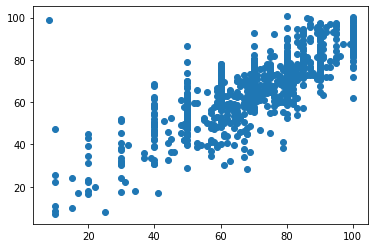

In [ ]:
plt.scatter(y_trues, y_hats)

## Weak Generalization

In [62]:
wuk = UserKNN(X)

In [63]:
wuk.gen_valid_idx()
wuk.split_test_weak()
wuk.gen_M()
wuk.gen_mu()

In [64]:
wuk.gen_corrcoef()

In [65]:
wuk.gen_preds()

In [66]:
y_trues = []
y_hats = []
for t in wuk.A_test_idx:
    i, j = t
    y_true = wuk.A[i,j]
    y_hat = wuk.P[i,j]
    y_trues.append(y_true)
    y_hats.append(y_hat)
    #print(f'True value: {y_true}')
    #print(f'Pred value: {}')
    #print(f'Delta: {abs(wuk.A[i,j] - wuk.P[i,j])}')
y_trues = np.array(y_trues)
y_hats = np.array(y_hats)

In [81]:
weak_gen_results = {
    'y_trues': y_trues.tolist(),
    'y_hats': y_hats.tolist(),
    'test_idx': [(int(i), int(j)) for i,j in wuk.A_test_idx]
}
with open('./preds/weak_generalization_8020_results_fullX.json', 'w') as fp:
    json.dump(weak_gen_results, fp)

#### WG Performance

In [82]:
print(f'Number of test predictions {len(wuk.A_test_idx)}')
print(f'Mean absolute error: {round(np.mean(abs(y_trues - y_hats)),2)}')
print(f'RMSE: {np.sqrt(np.mean((y_trues - y_hats)**2))}')

Number of test predictions 736944
Mean absolute error: 8.55
RMSE: 11.793278746840995


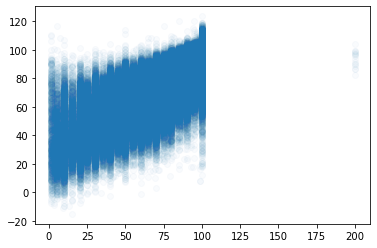

In [83]:
plt.scatter(x=y_trues, y=y_hats,alpha=0.025)

(array([3.00000e+00, 1.00000e+00, 2.00000e+00, 4.00000e+00, 1.70000e+01,
        2.30000e+01, 4.50000e+01, 8.30000e+01, 1.08000e+02, 1.80000e+02,
        2.82000e+02, 3.99000e+02, 6.34000e+02, 9.99000e+02, 1.42900e+03,
        2.22800e+03, 3.32400e+03, 5.15800e+03, 7.92400e+03, 1.26980e+04,
        2.16180e+04, 3.98400e+04, 7.49270e+04, 1.21700e+05, 1.45351e+05,
        1.25366e+05, 8.36730e+04, 4.67470e+04, 2.30400e+04, 1.04040e+04,
        4.69100e+03, 2.10900e+03, 9.29000e+02, 4.70000e+02, 2.55000e+02,
        1.18000e+02, 6.10000e+01, 3.10000e+01, 1.40000e+01, 1.80000e+01,
        9.00000e+00, 8.00000e+00, 4.00000e+00, 1.00000e+00, 2.00000e+00,
        1.00000e+00, 7.00000e+00, 2.00000e+00, 4.00000e+00, 3.00000e+00]),
 array([-112.05028696, -107.46129644, -102.87230591,  -98.28331539,
         -93.69432486,  -89.10533434,  -84.51634381,  -79.92735329,
         -75.33836276,  -70.74937224,  -66.16038171,  -61.57139118,
         -56.98240066,  -52.39341013,  -47.80441961,  -43.215429

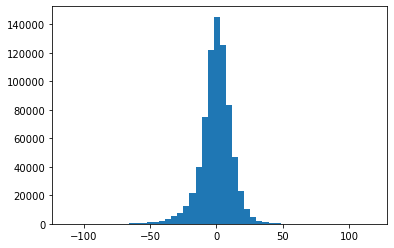

In [84]:
plt.hist(y_trues-y_hats, bins=50)

## Implicit Performance

### Weak Gen Perf

In [116]:
# Opening JSON file
f = open('./preds/weak_generalization_8020_results_fullX.json')
  
# returns JSON object as 
# a dictionary
wg_results = json.load(f)
y = np.array(wg_results['y_trues'])
y_hat = np.array(wg_results['y_hats'])
actual_threshold = 75
y_imp = (y >= actual_threshold)
y_hat_imp =(y_hat >= actual_threshold)


In [117]:
def gen_roc_values(y_implicit, y_hat, actual_threshold=75):
    tpr_list = []
    fpr_list = []
    color = []
    for i in range(100):
        thresh = i
        if thresh == actual_threshold:
            color.append('red')
        else:
            color.append('blue')
        y_hat_implicit =(y_hat >= thresh)
        tpr_list.append(np.sum(y_implicit * y_hat_implicit) / np.sum(y_implicit))

        if np.sum(~y_implicit) == 0:
            fpr_list.append(1)
        else:
            fpr_list.append(np.sum(~y_implicit * y_hat_implicit) / np.sum(~y_implicit))
    return tpr_list, fpr_list, color


In [118]:
y_implicit = (y >= actual_threshold)
wg_tpr_list, wg_fpr_list, wg_color = gen_roc_values(y_implicit, y_hat)

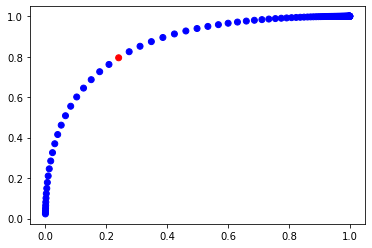

In [119]:
plt.scatter(x=wg_fpr_list, y=wg_tpr_list, color=wg_color)

In [120]:
def gen_uk_metrics(y_imp, y_hat_imp, threshold):
    precision = np.sum(y_imp * y_hat_imp) / np.sum(y_hat_imp)
    recall = np.sum(y_imp * y_hat_imp) / np.sum(y_imp)
    accuracy = np.sum(y_imp == y_hat_imp) / len(y_imp)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = (2 * precision * recall) / (precision + recall)
    metrics = {
        'n': len(y_hat_imp),
        'threshold': actual_threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'auc': None
    }
    return metrics

In [121]:
wg_metrics = gen_uk_metrics(y_imp, y_hat_imp, actual_threshold)
wg_metrics['auc'] = auc(x=wg_fpr_list, y=wg_tpr_list)
for k, v in wg_metrics.items():
    print(f'{k}: {round(v,4)}')

n: 736944
threshold: 75
precision: 0.851
recall: 0.7947
f1: 0.8219
accuracy: 0.7817
auc: 0.8608


### Strong Gen Perf

In [110]:
# Opening JSON file
f = open('./preds/strong_generalization_10raters_results.json')
  
# returns JSON object as 
# a dictionary
sg_results = json.load(f)
y_list = sg_results['y_trues']
y_hat_list = sg_results['y_hats']

y = []
y_hat = []
[y.extend(i) for i in y_list]
[y_hat.extend(i) for i in y_hat_list]
y_imp = np.array([i > actual_threshold for i in y])
y_hat_imp = np.array([i > actual_threshold for i in y_hat])


In [111]:
y_implicit = np.array(y) >= actual_threshold
sg_tpr_list, sg_fpr_list, sg_color = gen_roc_values(y_implicit, np.array(y_hat))

In [114]:
sg_metrics = gen_uk_metrics(y_imp, y_hat_imp, actual_threshold)
sg_metrics['auc'] = auc(x=sg_fpr_list, y=sg_tpr_list)

In [115]:
for k, v in sg_metrics.items():
    print(f'{k}: {round(v,4)}')

n: 1121
threshold: 75
precision: 0.8504
recall: 0.6243
f1: 0.72
accuracy: 0.7752
auc: 0.8873


In [107]:
print(f'MAE: {np.mean(abs(np.array(y) - np.array(y_hat)))}')
print(f'RMSE: {np.sqrt(np.mean((np.array(y) - np.array(y_hat))**2))}')

MAE: 8.165874569701026
RMSE: 10.687352078117772


In [93]:
wg_df = pd.DataFrame(
    {
        'thresh': range(0,100),
        'tpr': wg_tpr_list,
        'fpr': wg_fpr_list,
        'eval_method': ['weak'] * 100
    }
)
sg_df = pd.DataFrame(
    {
        'thresh': range(0,100),
        'tpr': sg_tpr_list,
        'fpr': sg_fpr_list,
        'eval_method': ['strong'] * 100
    }
)
benchmark = pd.DataFrame(
    {
            'thresh': range(0,100),
        'tpr': np.linspace(0,1,100),
        'fpr': np.linspace(0,1,100),
        'eval_method': ['benchmark'] * 100
        
    }
)

In [94]:
perf_df = pd.concat([sg_df, wg_df, benchmark], axis =0).reset_index()

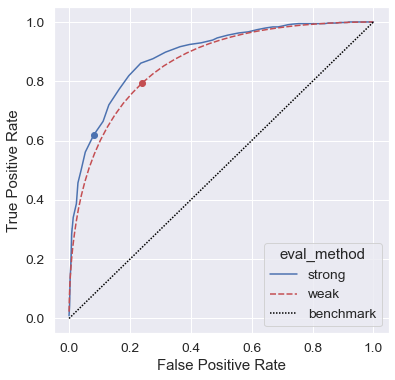

In [146]:
roc_palette = [sns.color_palette('deep')[0], sns.color_palette('deep')[3], 'black']
sns.set(font_scale=1.25)

fig, ax = plt.subplots(figsize=(6,6))
plot1 = sns.lineplot(data=perf_df, x='fpr', y='tpr', hue='eval_method', 
    style='eval_method',
    palette=roc_palette)

plt.scatter(sg_fpr_list[75], sg_tpr_list[75], marker='o', color=roc_palette[0])
plt.scatter(wg_fpr_list[75], wg_tpr_list[75], marker='o', color=roc_palette[1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig("../../paper/figures/user_knn_roc.pdf", bbox_inches='tight')